# Redes Bayesianas

## Dataset:

- Escolhi o dataset Credit Card Default, para calcular a probabilidade de inadiplência usando redes bayesianas.
- Esse dataset possui 30000 registros não nulos e 25 colunas:
  - Id
  - Limite de crédito
  - Sexo
  - Educação
  - Casamento
  - Idade
  - Pay_0 a Pay_6
  - Bill_Amt_0 a Bill_Amt_6
  - Pay_Amt_0 a Pay_Amt_6
  - Default.Payment.Next.Month
- A variável escolhida para fazer a análise é Default Payment a qual varia entre 0 e 1 indicando se o cliente pagou (1) ou se ele falhou em pagar (0).
- Toda essa análise dos registros foi feita utilizando as bibliotecas pandas, matplotlib e seahorn do python, utilizando o código a seguir.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ler o arquivo csv baixado do Kaggle
df = pd.read_csv('UCI_Credit_Card.csv', sep=',')

# Exibir as primeiras linhas
df.head()

# Informações sobre tipos de dados e valores ausentes
df.info()

# Estatísticas Gerais
df.describe()

ModuleNotFoundError: No module named 'pandas'

- Percebe-se, com os dados acima que não há valores nulos no dataset, o que facilita o tratamento visto que não é necessário tratar valores ausentes.

## Criando Histogramas:

- Como visto acima, só existem variáveis numéricas, isto é, int64 e float64, desse modo, vamos criar histogramas para analisar a distribuição de cada variável.

<Figure size 1400x800 with 0 Axes>

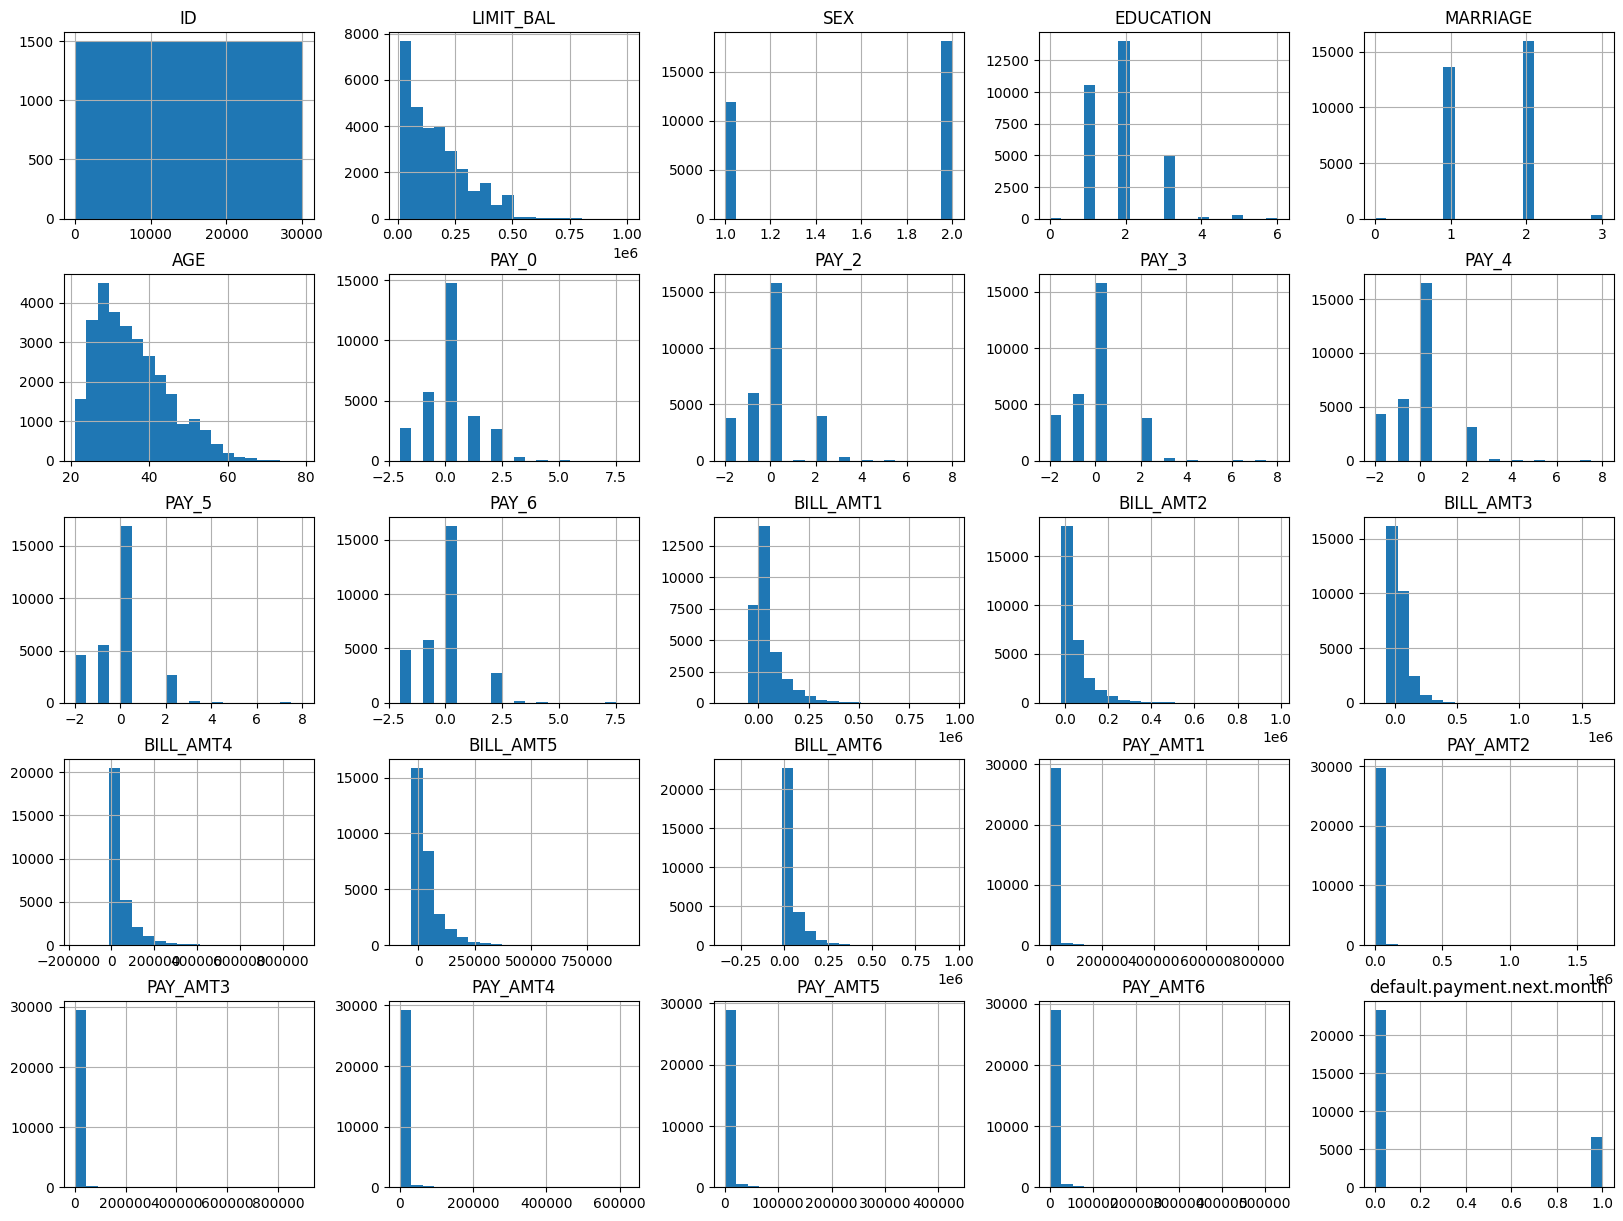

In [ ]:
# Seleciono todas as colunas que representam variáveis numéricas
numericas = df.select_dtypes(include=['int64', 'float64']).columns

# Plotando a figura com tamanho 1400x800 e criando os histogramas para
# cada coluna contida na lista numericas
plt.figure(figsize=(14, 8))
df[numericas].hist(bins=20, figsize=(20, 15))

plt.show()

- Criar os histogramas de cada variável numérica nos ajuda a entender se as variáveis têm uma distribuição normal, assimétrica, ou se contêm outliers. Por exemplo, valores de fatura ou de pagamento frequentemente têm distribuições assimétricas, onde a maioria dos valores está concentrada em uma faixa mais baixa, com alguns valores muito altos.

## Análise dos histogramas e das informações do dataset:

- Quais variáveis são discretas e quais são contínuas?

- Quais distribuições devem ser escolhidas para cada variável?

- Analisando os histogramas acima, percebe-se que nenhuma das variáveis se aproximam de uma distribuição normal. As variáveis LIMIT_BAL, BILL_AMT e PAY_AMT apresentam assimetria positiva, o que indica o melhor ajuste a uma distribuição log-normal ou exponencial.

- Como MARRIAGE, EDUCATION, AGE e PAY são variáveis discretas, então vamos aplicar uma distribuição categórica nelas, separando-as em categorias.

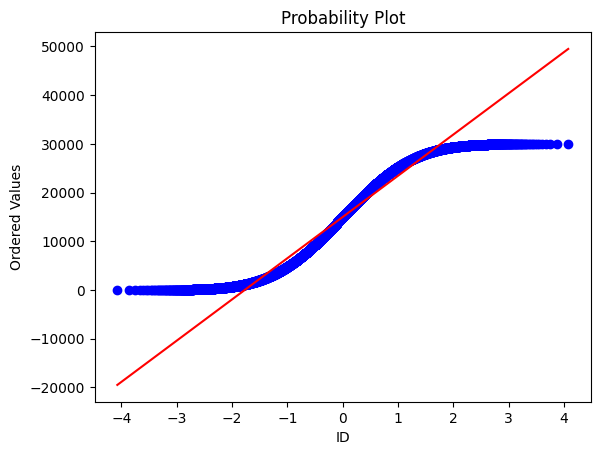

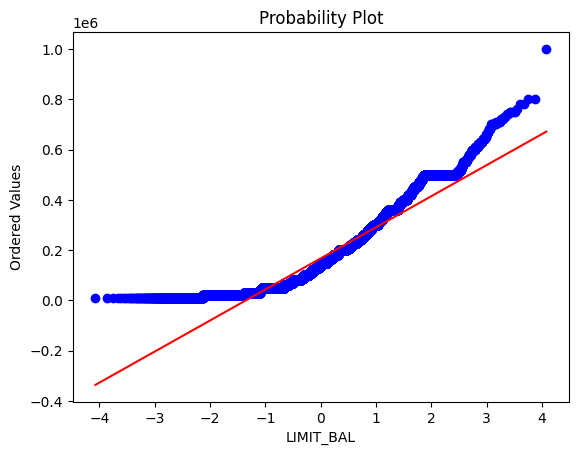

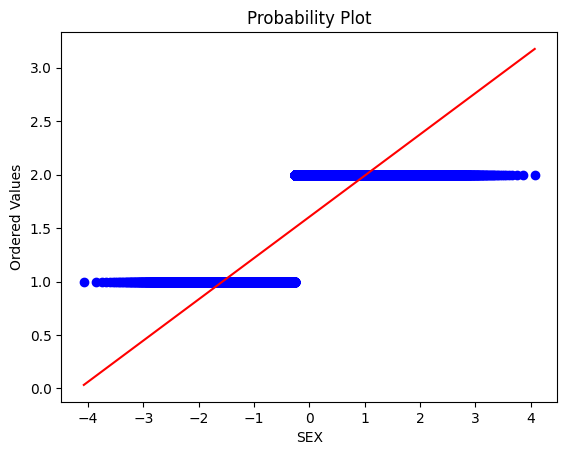

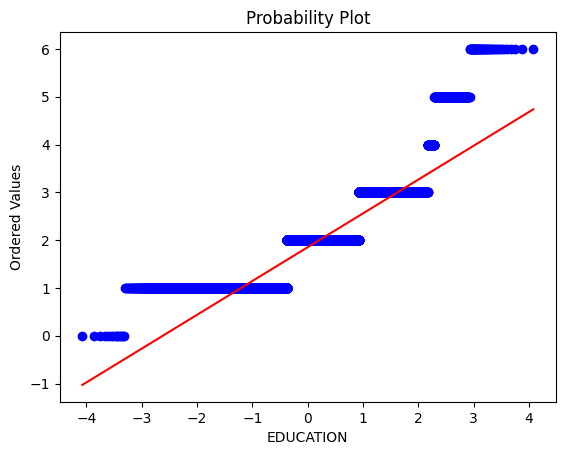

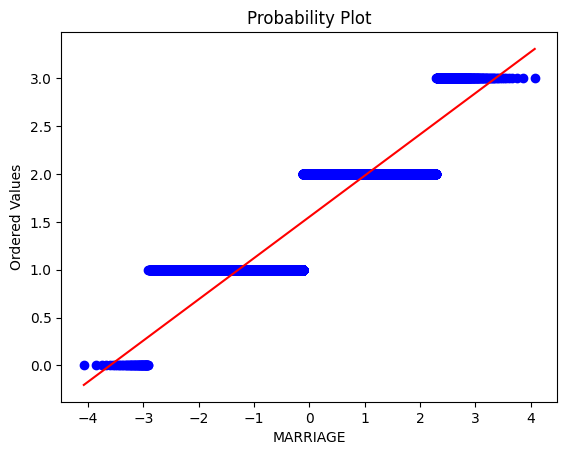

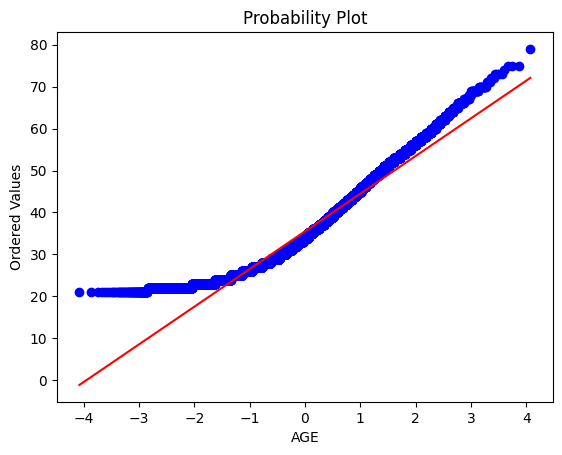

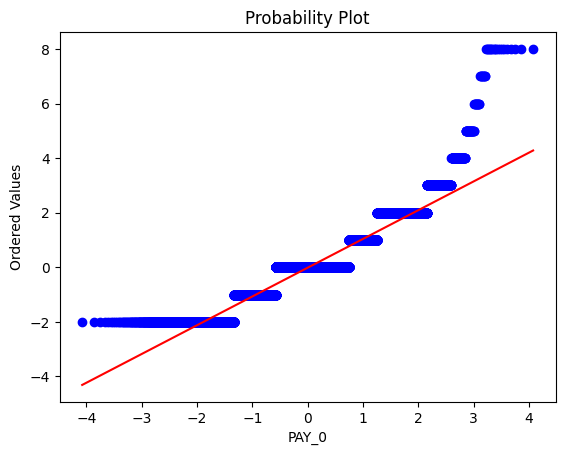

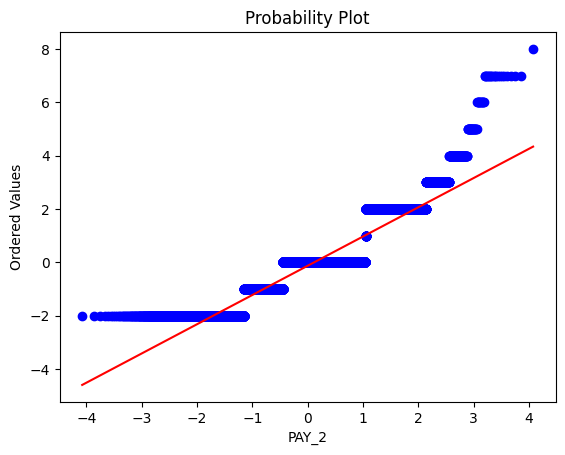

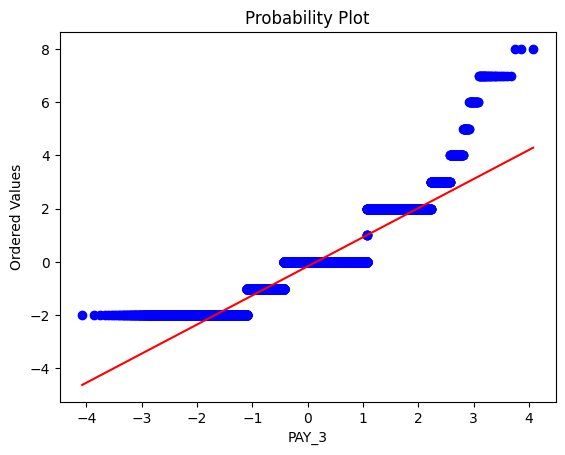

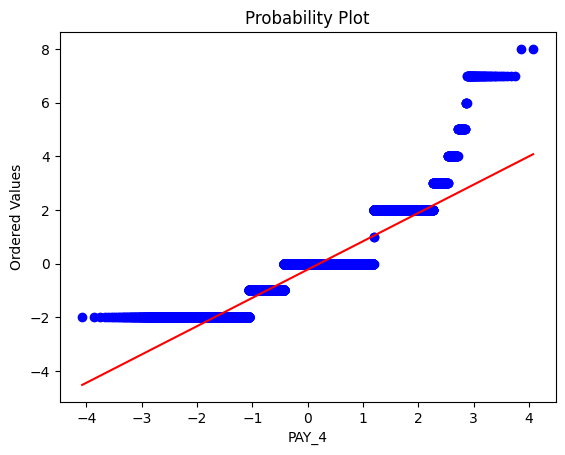

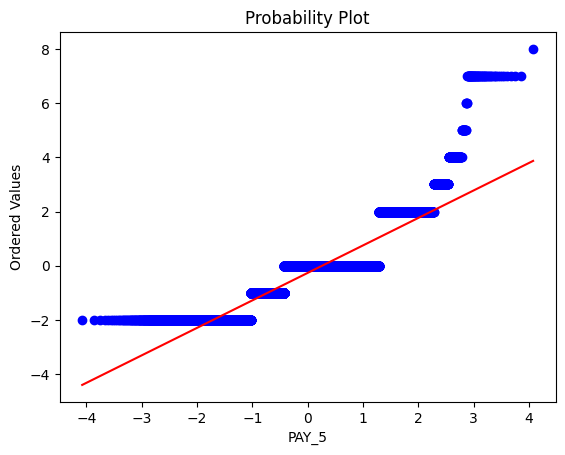

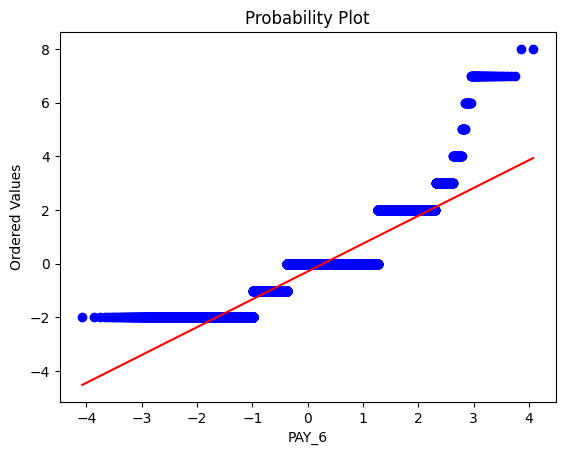

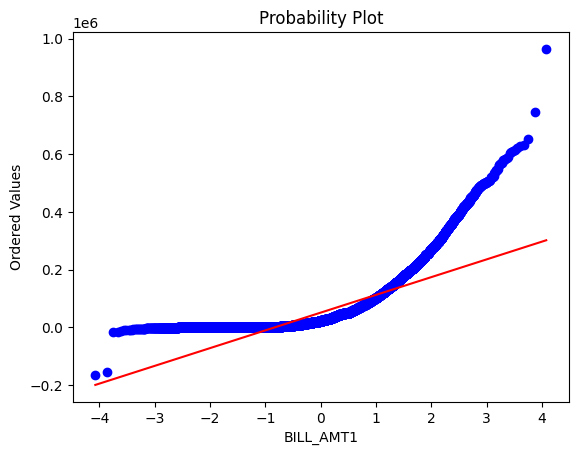

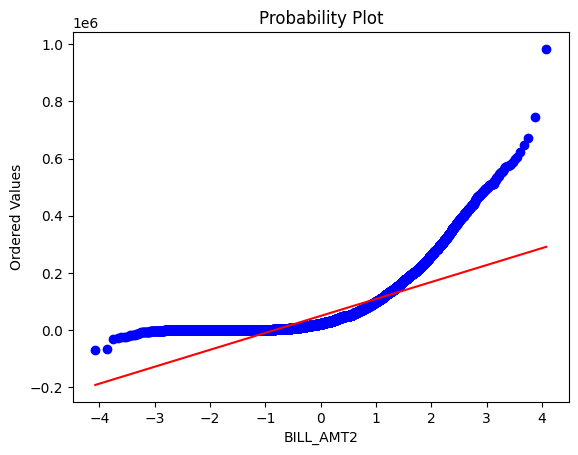

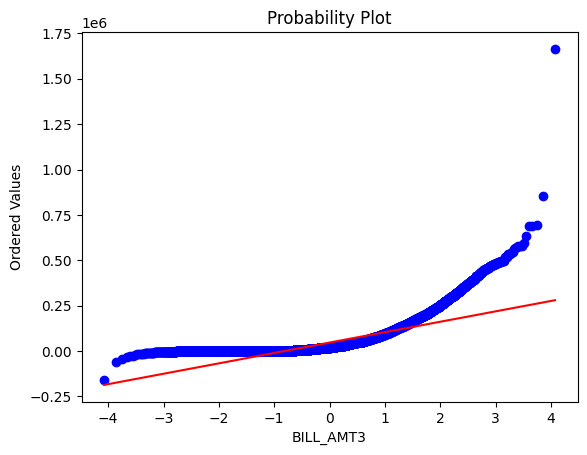

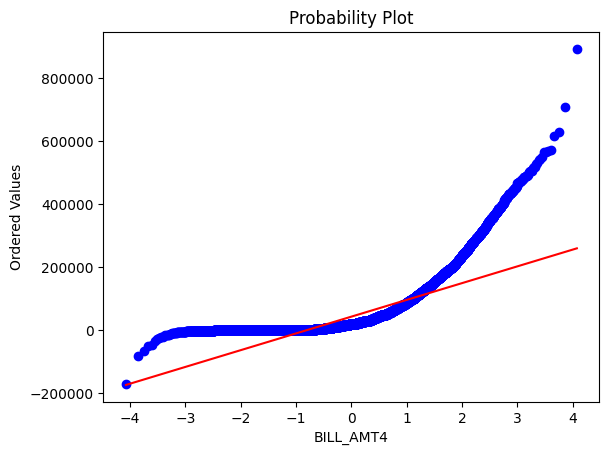

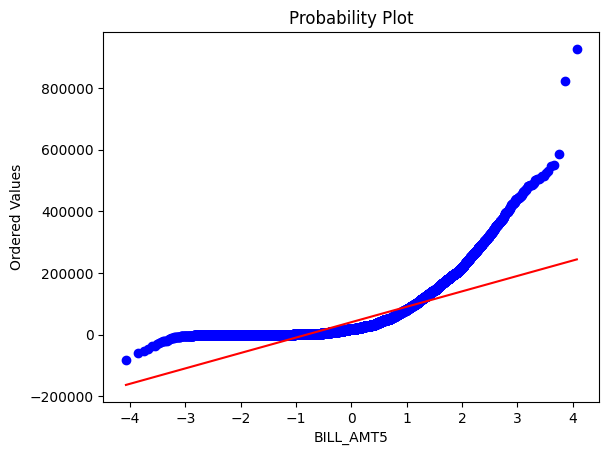

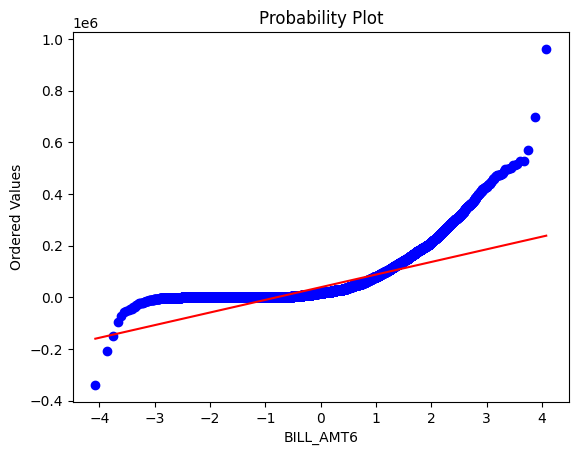

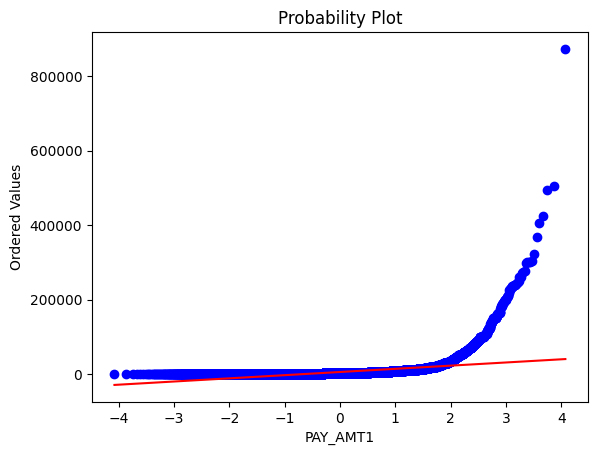

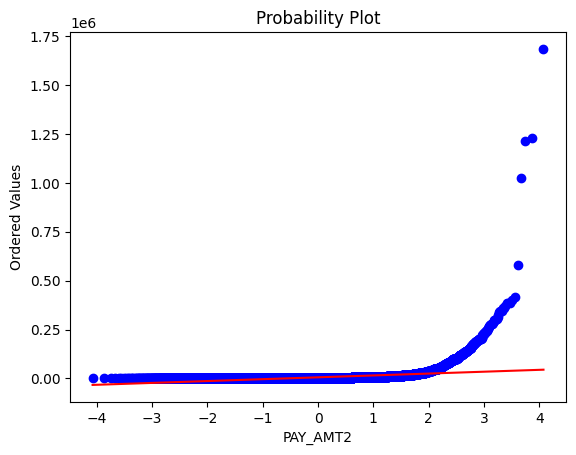

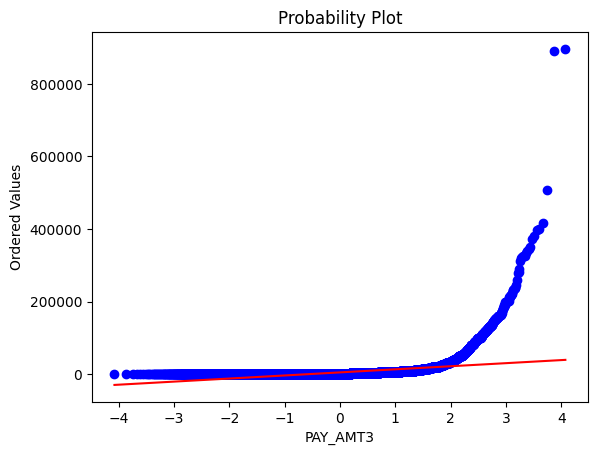

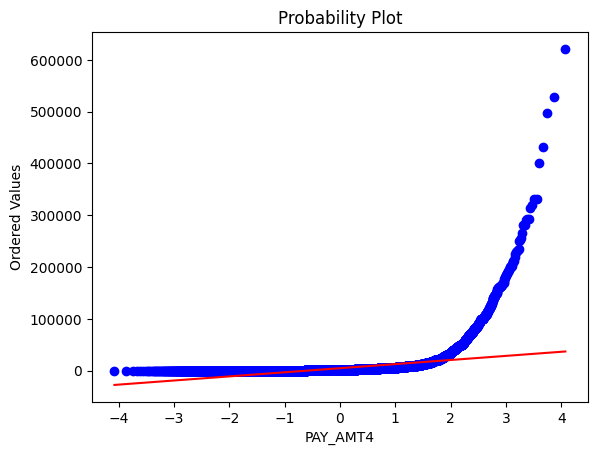

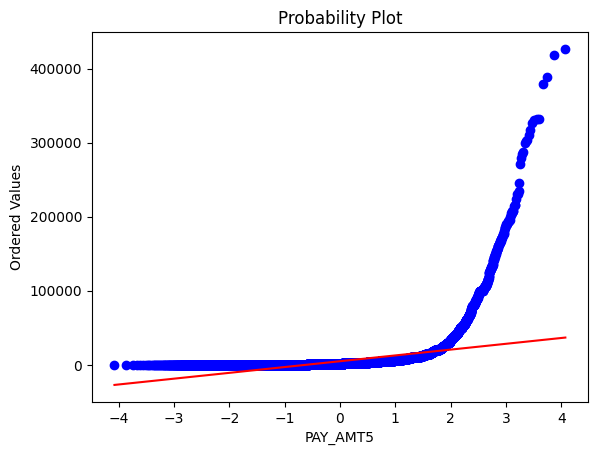

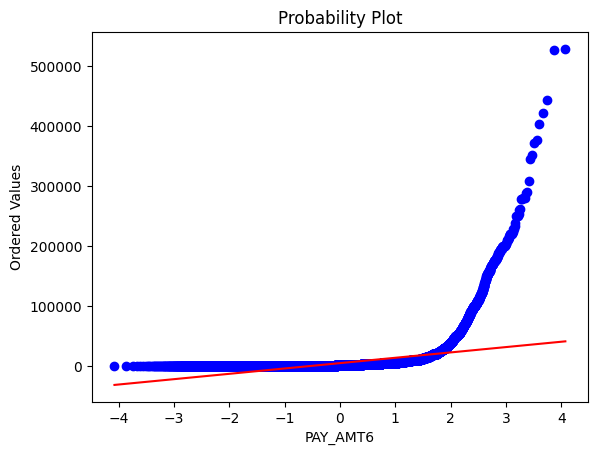

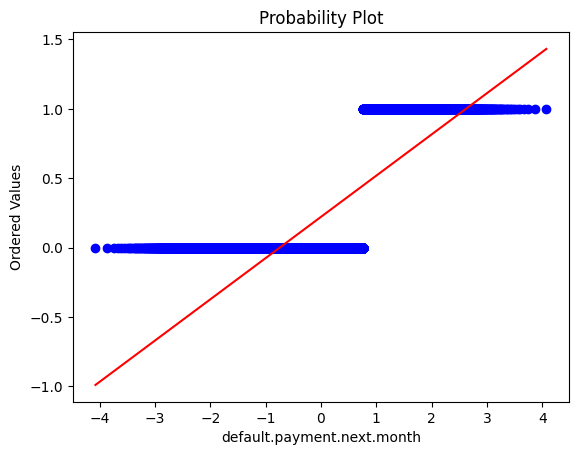

In [ ]:
import scipy.stats as stats

for coluna in numericas:
  stats.probplot(df[coluna], dist="norm", plot=plt)
  plt.xlabel(coluna);
  plt.show()


- Há um afastamento significativo dos pontos na parte superior direita, indicando a presença de uma cauda longa. Isso sugere que a variável LIMIT_BAL é assimétrica positiva, com uma quantidade menor de valores muito altos (outliers).

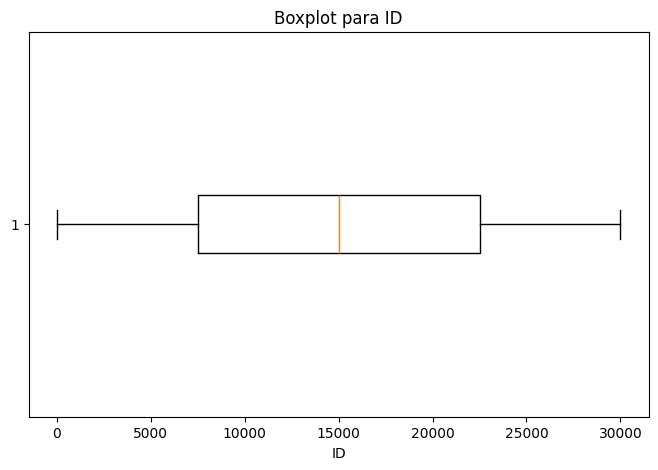

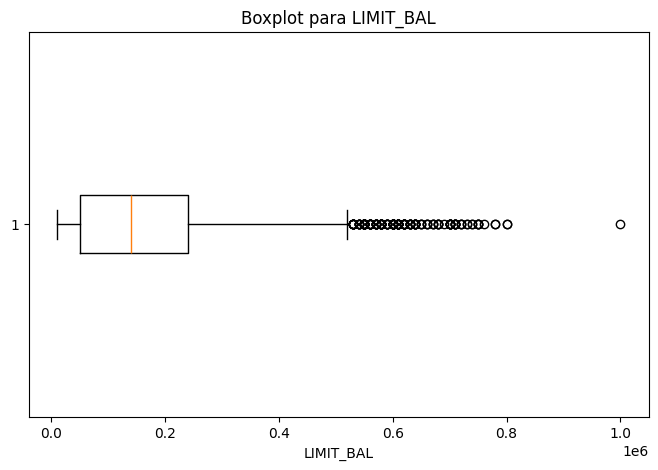

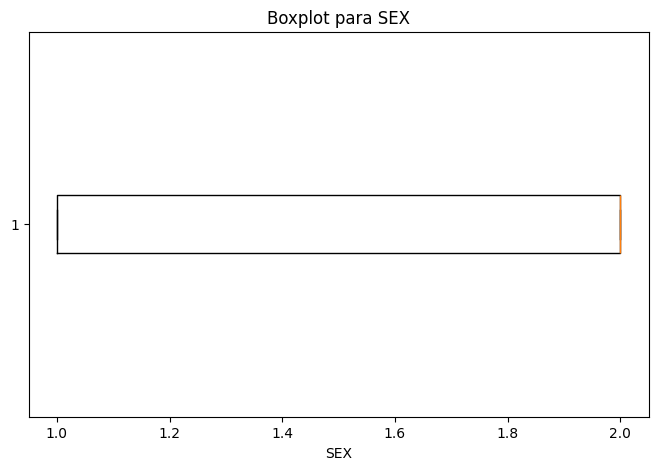

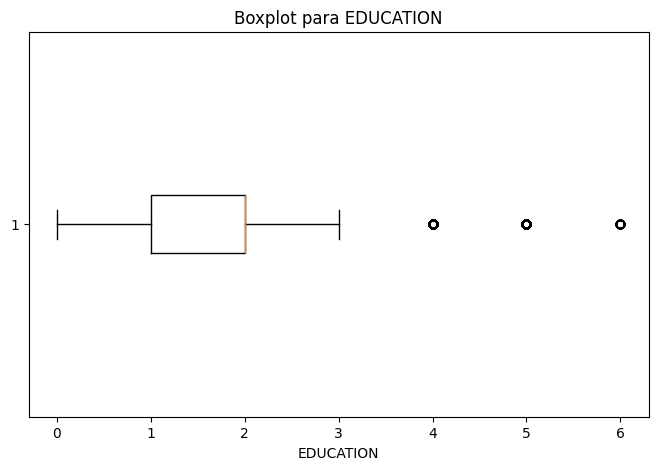

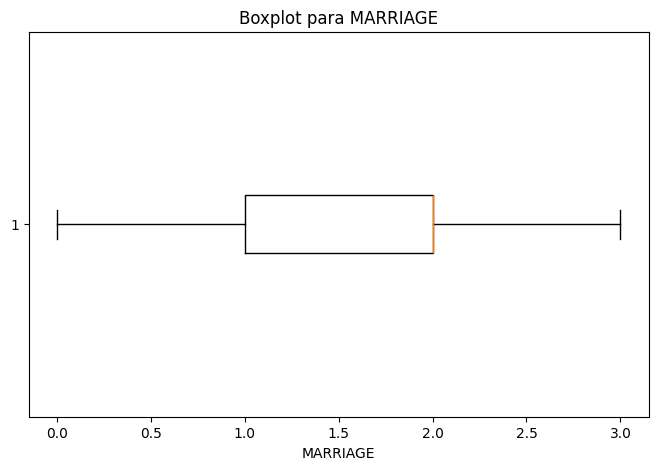

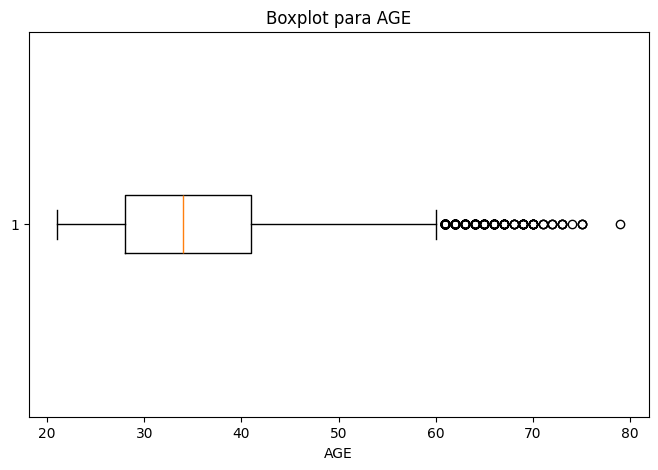

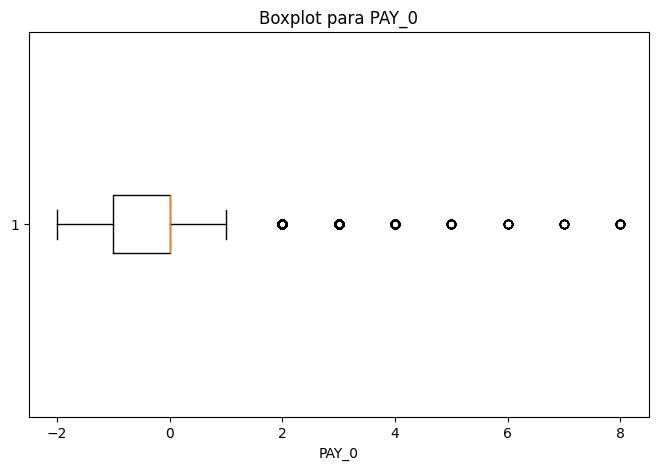

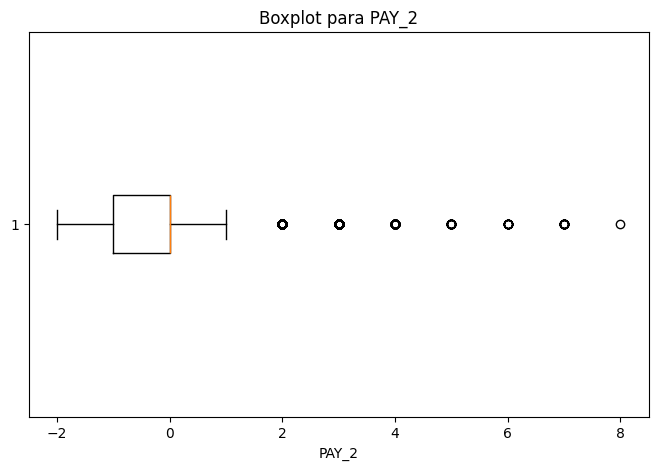

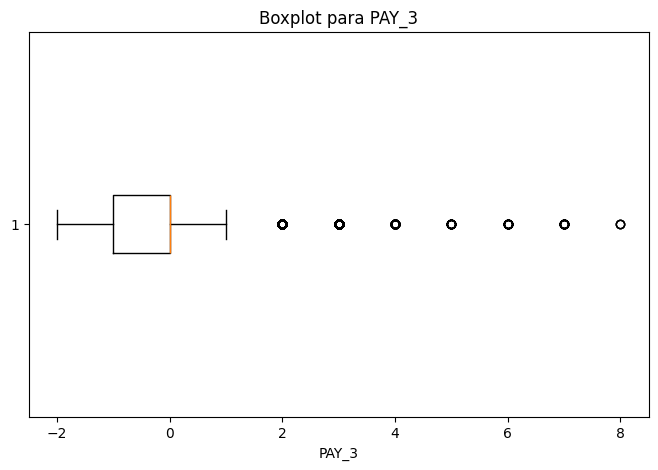

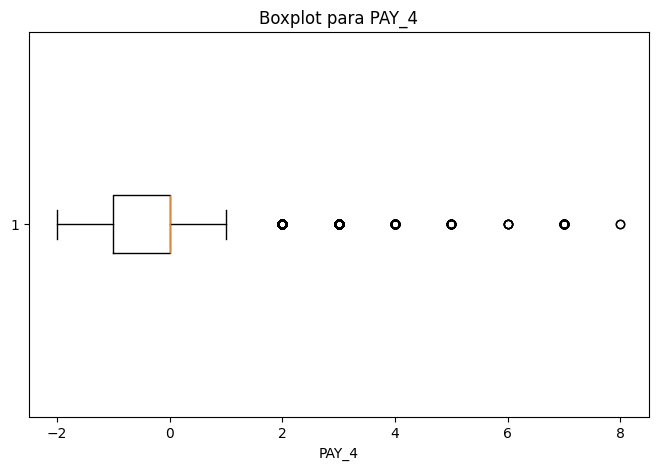

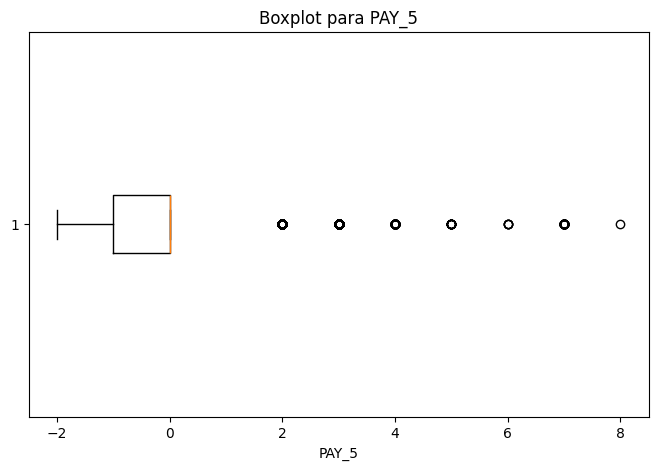

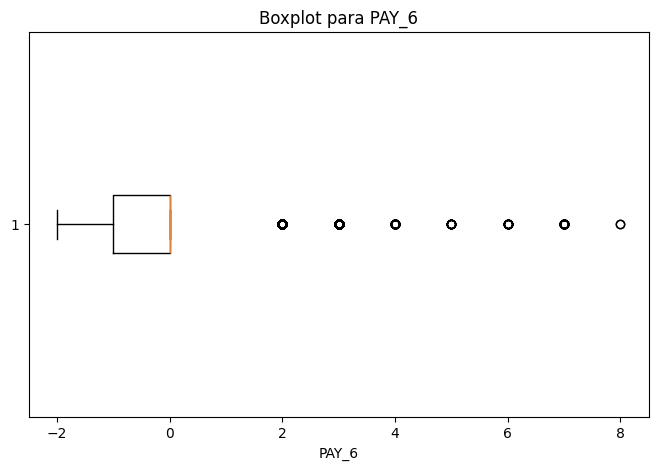

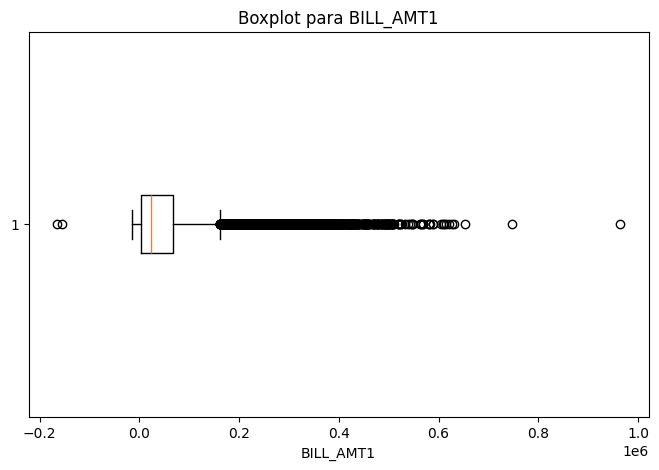

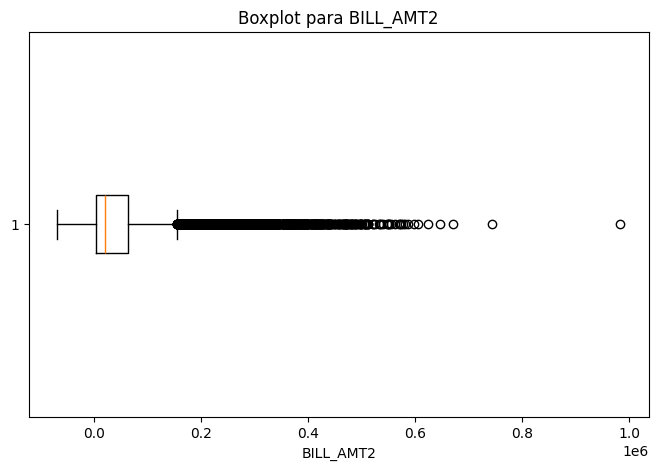

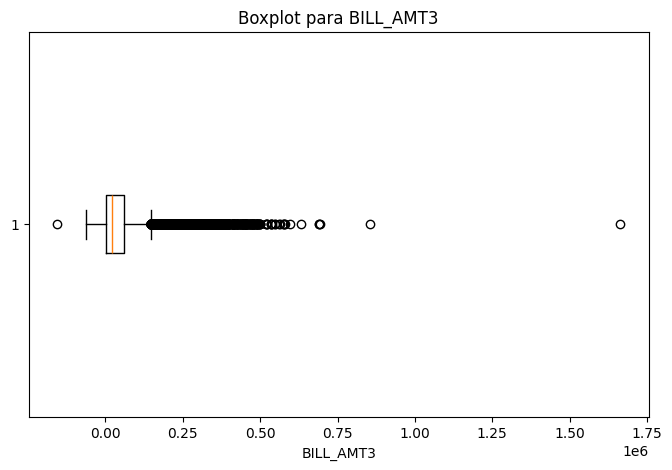

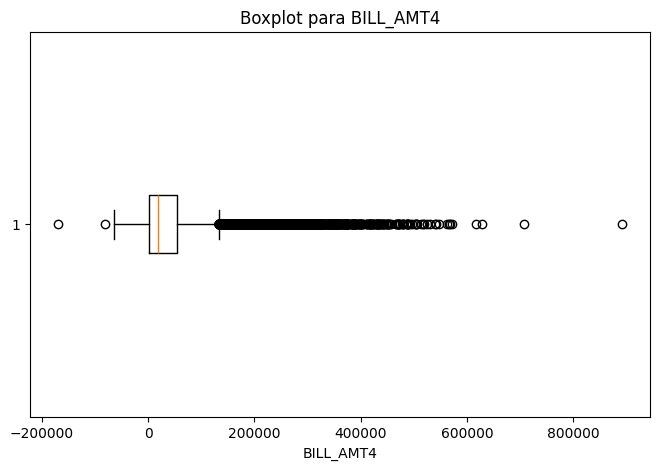

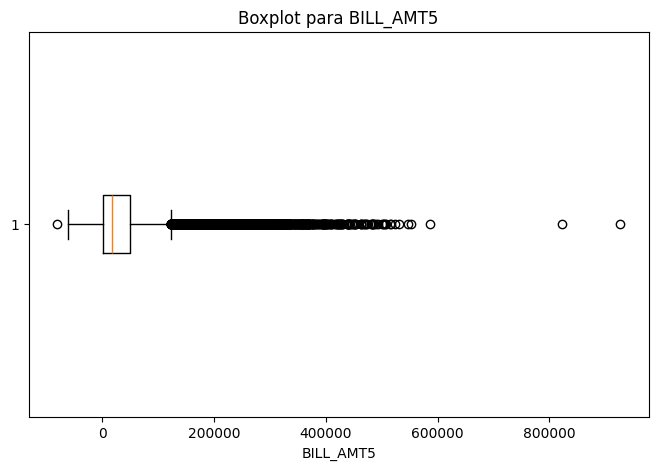

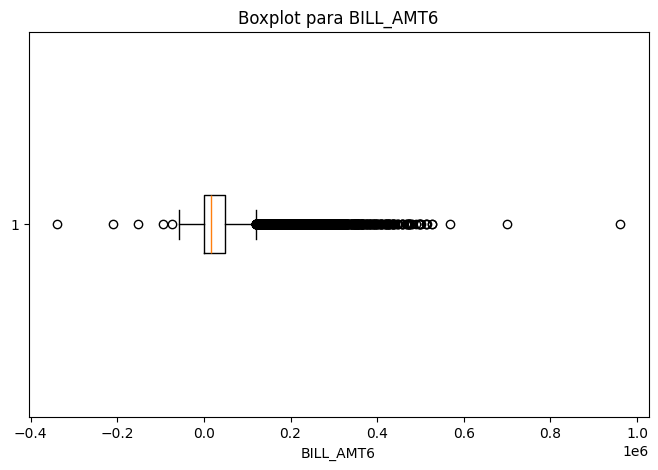

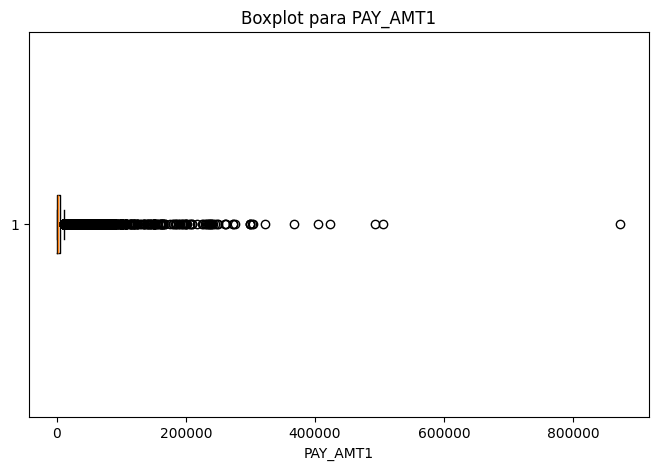

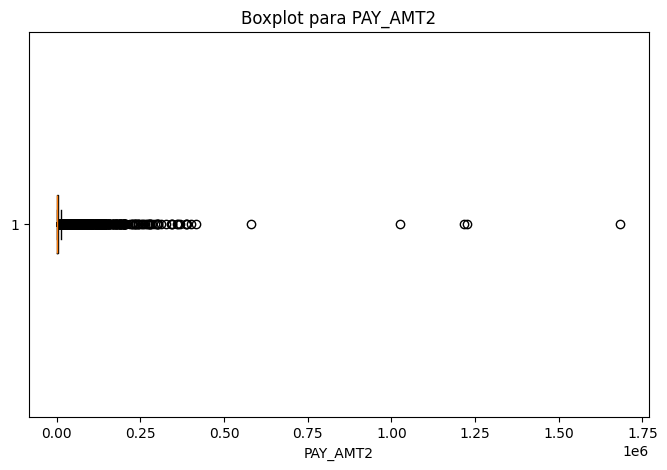

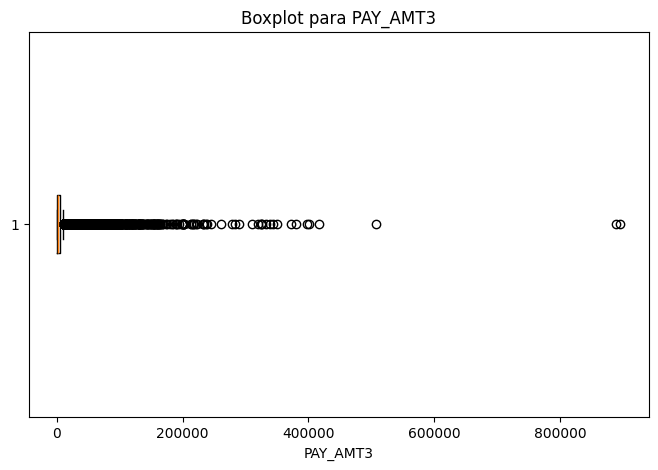

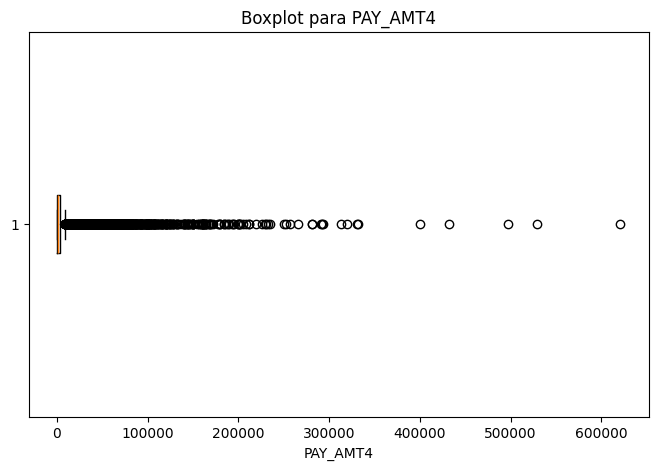

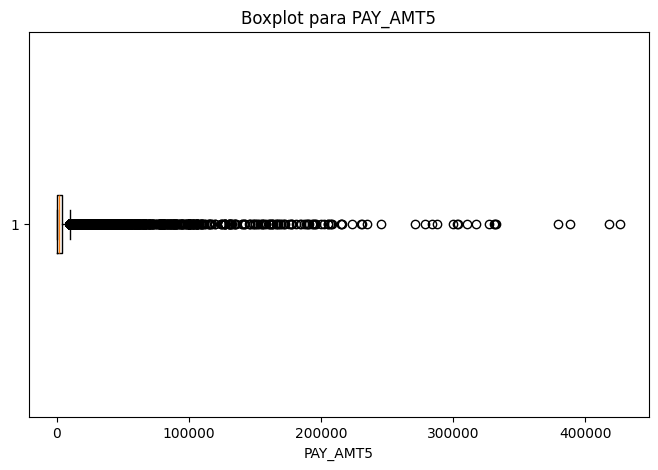

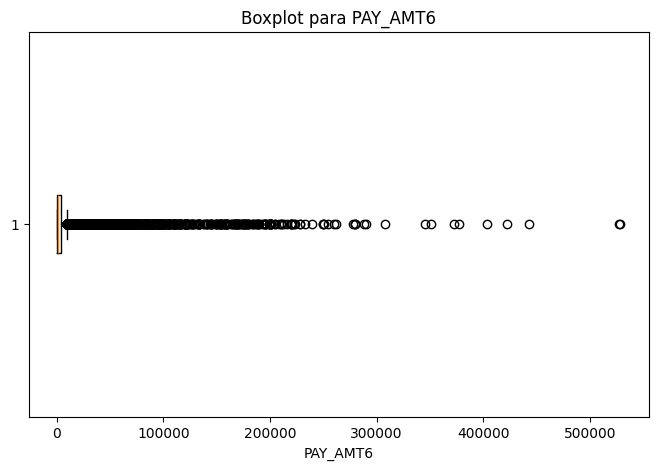

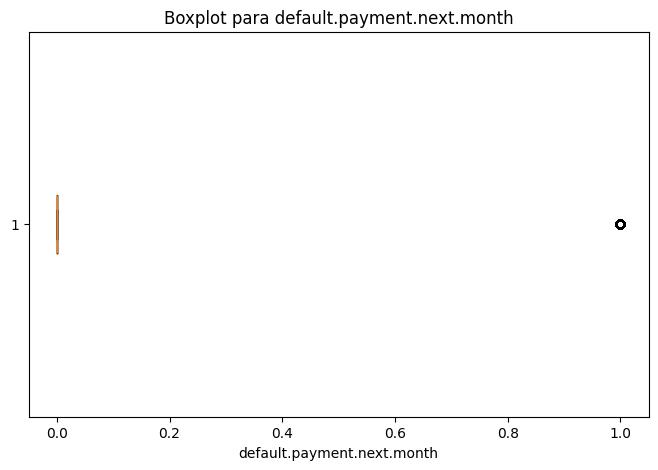

In [ ]:
# Boxplot para LIMIT_BAL
for coluna in numericas:
  plt.figure(figsize=(8, 5))
  plt.boxplot(df[coluna], vert=False)
  plt.title("Boxplot para " + coluna)
  plt.xlabel(coluna)
  plt.show()


- Utilizando esse gráfico BOXPLOT, percebe-se uma grande quantidade de outliers e assimetria positiva em PAY_AMT, BILL_AMT e LIMIT_BAL, logo para tentar minimizar essa situação vamos fazer uma transformação logarítmica para reduzir a assimetria e minimizar o impacto dos outliers.

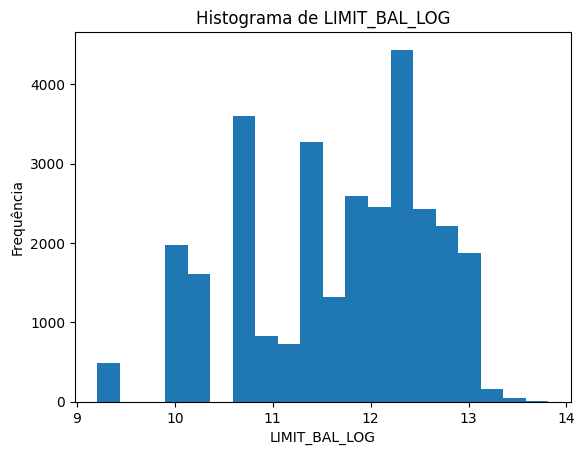

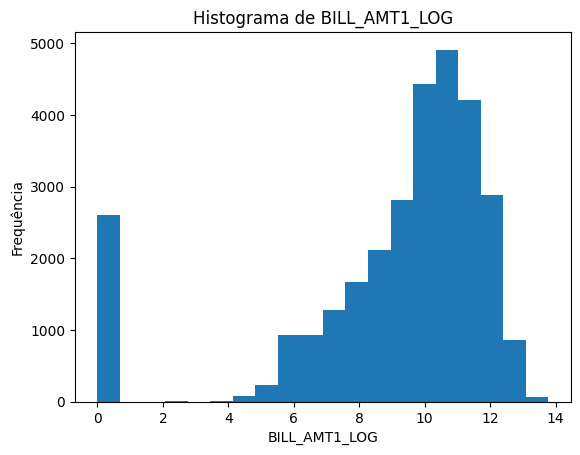

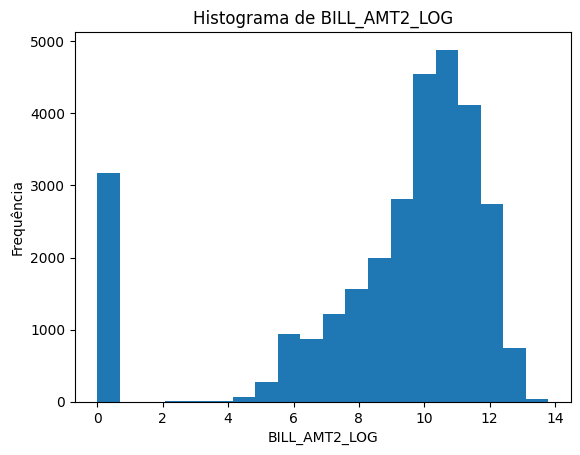

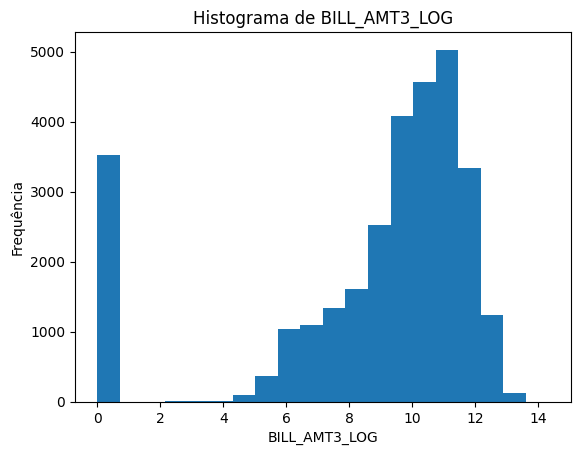

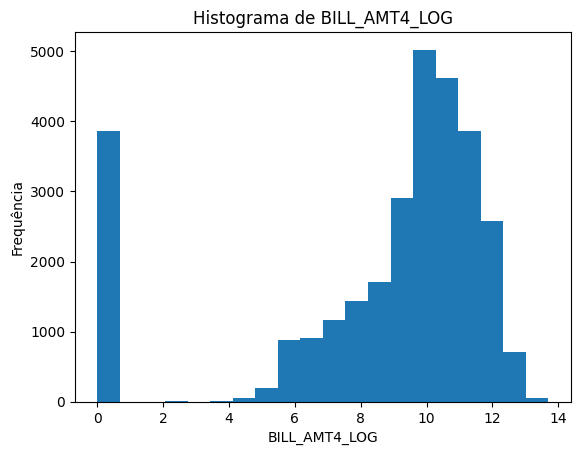

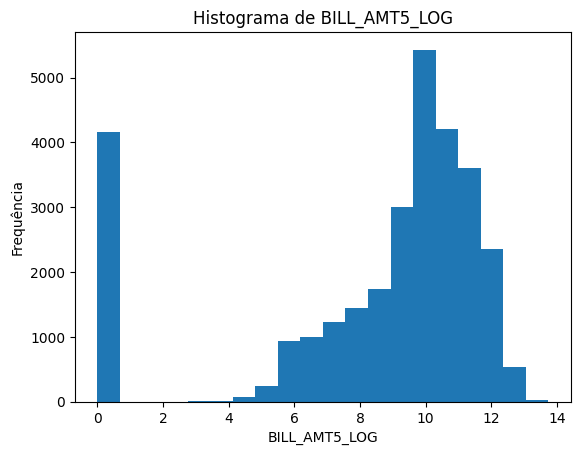

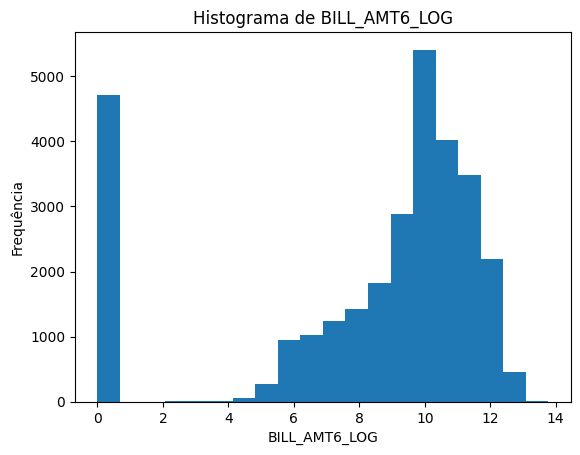

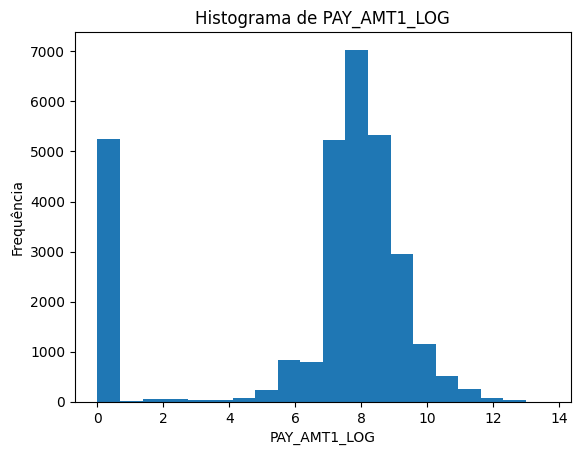

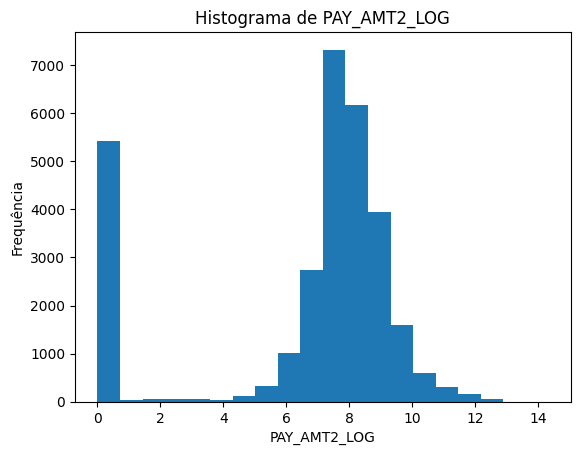

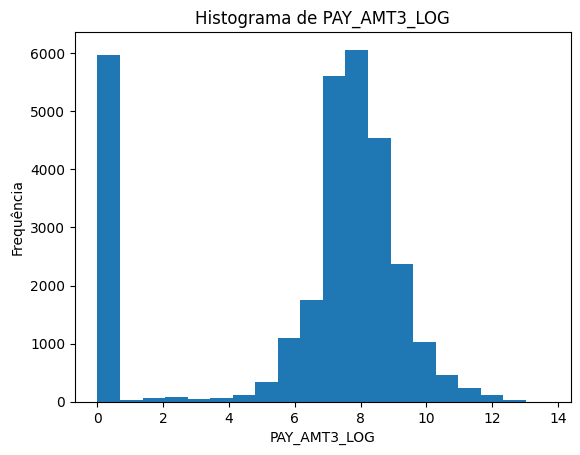

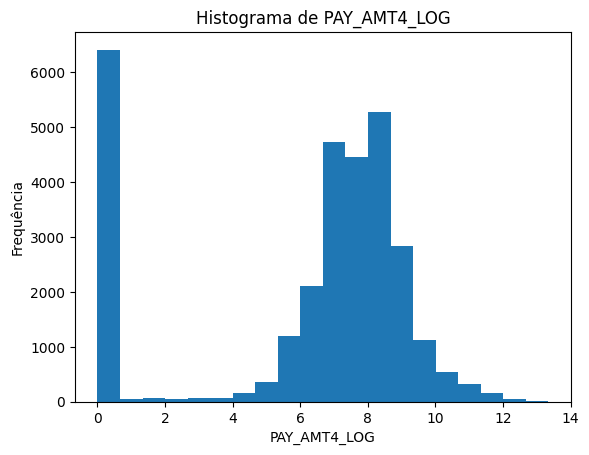

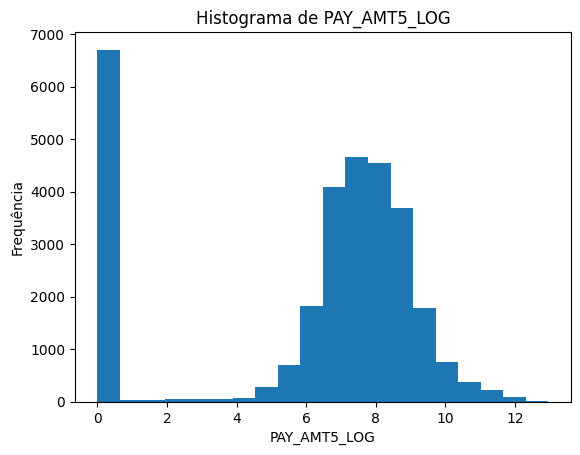

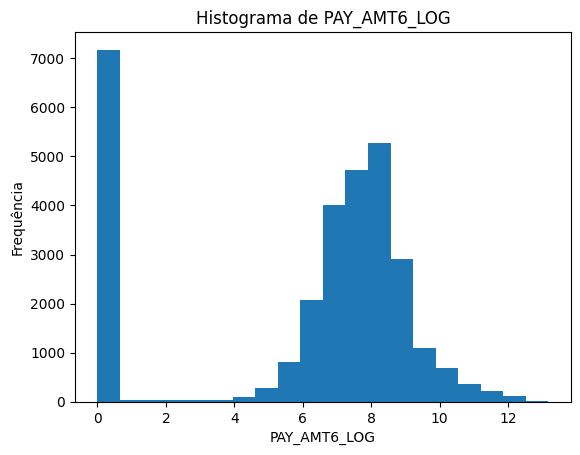

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Função para log-transformação, lidando com valores negativos e zero
def log_transform(column, replace_negatives=True):
    if replace_negatives:
        # Substitui valores negativos e zeros por um valor muito pequeno (1e-9)
        column = column.apply(lambda x: x if x > 0 else 1e-9)
    else:
        # Somente substitui zeros por 1e-9 (para colunas que têm zeros, como PAY_AMT)
        column = column.replace(0, 1e-9)
    return np.log(column + 1)  # Adiciona 1 para evitar log(0)

# Aplicar transformação logarítmica em LIMIT_BAL
df['LIMIT_BAL_LOG'] = log_transform(df['LIMIT_BAL'], replace_negatives=False)

# Aplicar transformação logarítmica em BILL_AMT1 a BILL_AMT6 (substituir negativos por 1e-9)
for i in range(1, 7):
    df[f'BILL_AMT{i}_LOG'] = log_transform(df[f'BILL_AMT{i}'], replace_negatives=True)

# Aplicar transformação logarítmica em PAY_AMT1 a PAY_AMT6 (substituir zeros por 1e-9)
for i in range(1, 7):
    df[f'PAY_AMT{i}_LOG'] = log_transform(df[f'PAY_AMT{i}'], replace_negatives=False)

# Visualizar histogramas das variáveis transformadas
for col in ['LIMIT_BAL_LOG'] + [f'BILL_AMT{i}_LOG' for i in range(1, 7)] + [f'PAY_AMT{i}_LOG' for i in range(1, 7)]:
    plt.hist(df[col], bins=20)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.show()





- Documente que a transformação logarítmica foi aplicada e justifique o motivo, mencionando a redução da assimetria e a estabilização das variáveis financeiras (como BILL_AMT6), o que melhora a performance e a interpretação do modelo bayesiano.

- Veja que BILL_AMT e PAY_AMT possuem uma grande quantidade de valores próximos de 0, isso ocorreu, pois BILL_AMT possuia valores negativos, os quais ocasionavam erros durante o processo de transformação, já PAY_AMT por padrão já possui valores iguais a 0.

- Então preferi transformar os valores negativos em 0 envés de remové-los.

## Separando idade por faixa etaria e trasformando marriage, pay_ e education em variáveis categóricas:

- Como idade possui uma grande quantidade de valores que variam entre 21 e 79, vamos criar faixas etárias para separar essas pessoas em grupos:
 - 21 a 30
 - 31 a 40
 - 41 a 50
 - 51 a 60
 - 61 a 70
 - 71 a 80

- Como marriage, pay_ e education devem ser tratadas como variáveis categóricas, vamos converter essas variáveis no dataframe como categóricas.

In [ ]:

# Definir as faixas etárias e os rótulos
bins = [20, 30, 40, 50, 60, 70, 80]  # Limites das faixas
labels = ['21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

# Criar uma nova coluna para as faixas etárias
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

# Converter as variáveis para o tipo categórico
df['MARRIAGE'] = df['MARRIAGE'].astype('category')
df['EDUCATION'] = df['EDUCATION'].astype('category')
df['PAY_0'] = df['PAY_0'].astype('category')
df['PAY_2'] = df['PAY_2'].astype('category')
df['PAY_3'] = df['PAY_3'].astype('category')
df['PAY_4'] = df['PAY_4'].astype('category')
df['PAY_5'] = df['PAY_5'].astype('category')
df['PAY_6'] = df['PAY_6'].astype('category')
df['AGE_GROUP'] = df['AGE_GROUP'].astype('category')  # Faixa etária também como categórica

df.head()



,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4_LOG,BILL_AMT5_LOG,BILL_AMT6_LOG,PAY_AMT1_LOG,PAY_AMT2_LOG,PAY_AMT3_LOG,PAY_AMT4_LOG,PAY_AMT5_LOG,PAY_AMT6_LOG,AGE_GROUP
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,6.536692,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,21-30
1,2,120000.0,2,2,2,26,-1,2,0,0,...,8.093462e+00,8.147867e+00,8.090096e+00,1.000000e-09,6.908755,6.908755e+00,6.908755e+00,1.000000e-09,7.601402e+00,21-30
2,3,90000.0,2,2,2,34,0,0,0,0,...,9.570250e+00,9.612400e+00,9.651816e+00,7.325808e+00,7.313887,6.908755e+00,6.908755e+00,6.908755e+00,8.517393e+00,31-40
3,4,50000.0,2,2,1,37,0,0,0,0,...,1.025115e+01,1.027367e+01,1.029377e+01,7.601402e+00,7.610853,7.090910e+00,7.003974e+00,6.975414e+00,6.908755e+00,31-40
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,9.949464e+00,9.859901e+00,9.859118e+00,7.601402e+00,10.510041,9.210440e+00,9.105091e+00,6.536692e+00,6.522093e+00,51-60


## Criando a matriz de correlação:

- Para analisar a correlação entre as variáveis numéricas, vamos criar uma matriz de correlação usando a biblioteca seaborn

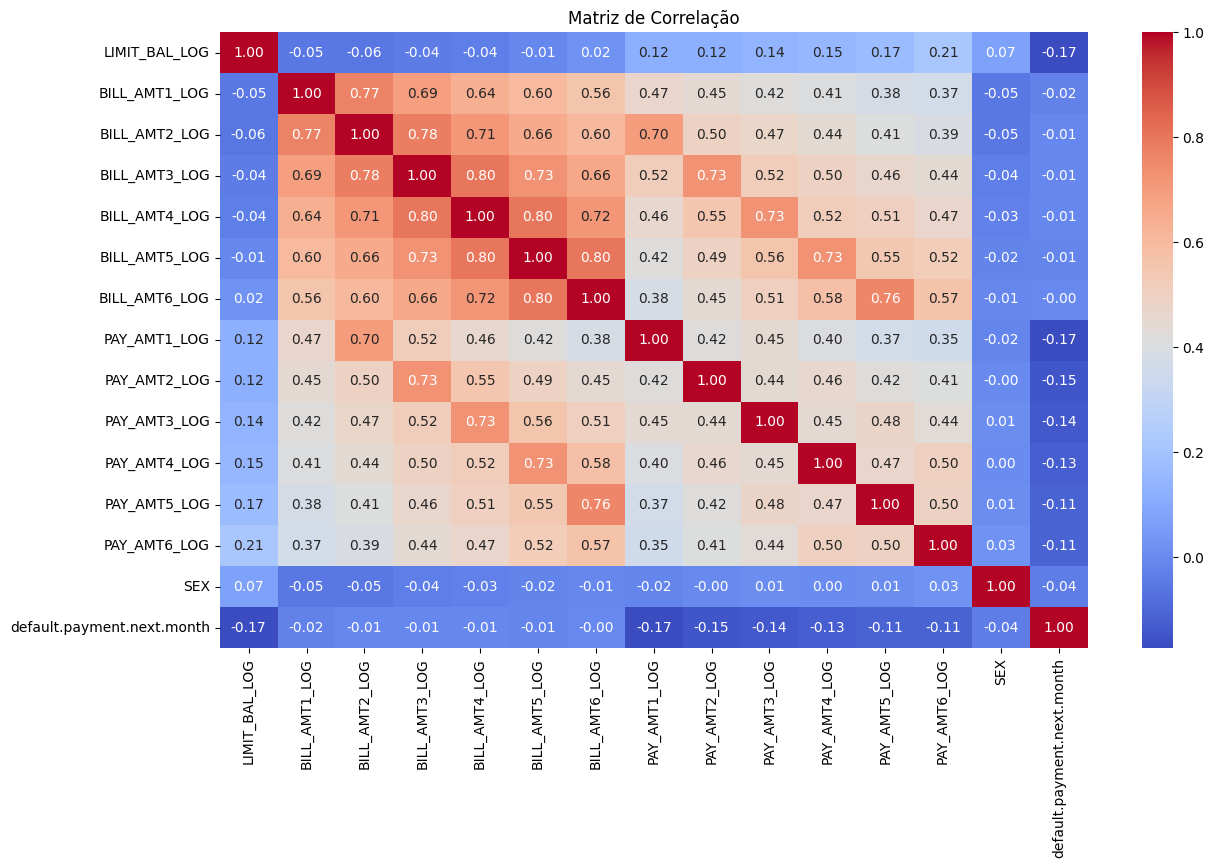

In [ ]:
# Filtrar as variáveis numéricas para a matriz de correlação
numerical_variables = [
    'LIMIT_BAL_LOG', 'BILL_AMT1_LOG', 'BILL_AMT2_LOG', 'BILL_AMT3_LOG',
    'BILL_AMT4_LOG', 'BILL_AMT5_LOG', 'BILL_AMT6_LOG',
    'PAY_AMT1_LOG', 'PAY_AMT2_LOG', 'PAY_AMT3_LOG', 'PAY_AMT4_LOG',
    'PAY_AMT5_LOG', 'PAY_AMT6_LOG', 'SEX',
    'default.payment.next.month'  # Variável alvo
]

# Gerar a matriz de correlação apenas com variáveis numéricas
plt.figure(figsize=(14, 8))
sns.heatmap(df[numerical_variables].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()



- Percebe-se que às variáveis LIMIT_BAL possue uma certa relação com a variável alvo, apresentando que a medida que o limite de crédito aumenta, a chance de uma pessoa ser inadimplente diminui, o que faz sentido.

- Como LIMIT_BAL, PAY_AMT_LOG são variáveis que possuem uma correlação significativa com a variável alvo elas serão variáveis principais.

- BILL_AMT_LOG será secundária, pois, embora não se correlacionem fortemente com a inadimplência, fornecem informações contextuais importantes sobre o nível de dívida do cliente.

- A variável SEX não será incluída na rede devido à sua baixa correlação com a variável alvo e com qualquer outra variável.

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# Função para calcular o teste qui-quadrado entre cada variável categórica e a variável alvo
categorical_vars = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'MARRIAGE', 'EDUCATION', 'AGE_GROUP']
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['default.payment.next.month'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Variável: {var}, Qui-quadrado: {chi2}, Valor-p: {p}")


Variável: PAY_0, Qui-quadrado: 5365.964977413581, Valor-p: 0.0
Variável: PAY_2, Qui-quadrado: 3474.4667904168564, Valor-p: 0.0
Variável: PAY_3, Qui-quadrado: 2622.4621276828025, Valor-p: 0.0
Variável: PAY_4, Qui-quadrado: 2341.469945438205, Valor-p: 0.0
Variável: PAY_5, Qui-quadrado: 2197.694900930992, Valor-p: 0.0
Variável: PAY_6, Qui-quadrado: 1886.835309001187, Valor-p: 0.0
Variável: MARRIAGE, Qui-quadrado: 35.66239583433609, Valor-p: 8.825862457577375e-08
Variável: EDUCATION, Qui-quadrado: 163.21655786997073, Valor-p: 1.2332626245415605e-32
Variável: AGE_GROUP, Qui-quadrado: 46.16684021557162, Valor-p: 8.398778505133663e-09


### Interpretação do teste qui-quadrado:

- Como a matriz de correlação não pode ser usada para variáveis categóricas usamos o teste qui-quadrado para saber sobre as relações entre pay_, marriage, education e age_group.

- O teste qui-quadrado funciona da seguinte maneira, se o valor-p for pequeno, menor que 0.05, isso indicaria uma associação estatisticamente significativa entre a variável e a variável alvo.

- Se o valor-p for alto, maior que 0,05, isso sugeriria que a variável não está significativamente associado à inadimplência.

- Como visto nos resultados acima, todas as variáveis testadas apresentaram p menor que 0.05, o que indica que elas devem ser levadas em consideração, veja que o valor p das variáveis PAY_ é igual a 0 o que indica uma forte correlação com a variável alvo, logo elas serão variáveis principais, as variáveis AGE_GROUP, MARRIAGE e EDUCATION serão variáveis secundárias pois são significativas porém de menor impacto.

  ## Variáveis principais e secundárias, suas distribuições e tipos:
### Variáveis Principais
- Essas variáveis têm uma associação mais forte com a inadimplência, tanto por correlação quanto por teste qui-quadrado.

- LIMIT_BAL_LOG (correlação negativa com a variável alvo)
- PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6 (forte associação no teste qui-quadrado)
- PAY_AMT1_LOG, PAY_AMT2_LOG, PAY_AMT3_LOG, PAY_AMT4_LOG, PAY_AMT5_LOG, PAY_AMT6_LOG (valores de pagamento)

### Variáveis Secundárias
- Essas variáveis têm associações mais fracas com a variável alvo, mas ainda são relevantes para contexto adicional.

- MARRIAGE (significativo no teste qui-quadrado, mas de menor impacto)
- EDUCATION (associação significativa com a inadimplência)
- AGE_GROUP (agora confirmado com associação significativa no teste qui-quadrado)
- BILL_AMT1_LOG, BILL_AMT2_LOG, BILL_AMT3_LOG, BILL_AMT4_LOG, BILL_AMT5_LOG, BILL_AMT6_LOG (fornecem contexto sobre o saldo de dívida)

### Distribuições:

- Limit_bal_log, pay_amt_log e bill_amt_log irão utilizar a distribuição log-normal, pois a transformação logarítmica nelas foi ótima.

- Marriage, education, pay_0 a pay_6 e age_group irão utilizar a distribuição categórica por serem variáveis categóricas.

## Construindo a Rede Bayesiana

### Distribuição Normal para Variáveis Contínuas (Numéricas)


Separando o DF com apenas variáveis numéricas

In [ ]:
# Listas de variáveis numéricas e categóricas
numeric_vars = [
    'LIMIT_BAL_LOG',
    'PAY_AMT1_LOG', 'PAY_AMT2_LOG', 'PAY_AMT3_LOG', 'PAY_AMT4_LOG', 'PAY_AMT5_LOG', 'PAY_AMT6_LOG',
    'BILL_AMT1_LOG', 'BILL_AMT2_LOG', 'BILL_AMT3_LOG', 'BILL_AMT4_LOG', 'BILL_AMT5_LOG', 'BILL_AMT6_LOG'
]

# Criar DataFrames separados
df_numeric = df[numeric_vars]

# Verificação das primeiras linhas para garantir que os dados foram divididos corretamente
df_numeric.head()

,LIMIT_BAL_LOG,PAY_AMT1_LOG,PAY_AMT2_LOG,PAY_AMT3_LOG,PAY_AMT4_LOG,PAY_AMT5_LOG,PAY_AMT6_LOG,BILL_AMT1_LOG,BILL_AMT2_LOG,BILL_AMT3_LOG,BILL_AMT4_LOG,BILL_AMT5_LOG,BILL_AMT6_LOG
0,9.903538,1.000000e-09,6.536692,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,8.272315,8.040125,6.536692,1.000000e-09,1.000000e-09,1.000000e-09
1,11.695255,1.000000e-09,6.908755,6.908755e+00,6.908755e+00,1.000000e-09,7.601402e+00,7.894691,7.453562,7.894691,8.093462e+00,8.147867e+00,8.090096e+00
2,11.407576,7.325808e+00,7.313887,6.908755e+00,6.908755e+00,6.908755e+00,8.517393e+00,10.283293,9.548811,9.514880,9.570250e+00,9.612400e+00,9.651816e+00
3,10.819798,7.601402e+00,7.610853,7.090910e+00,7.003974e+00,6.975414e+00,6.908755e+00,10.757711,10.783819,10.805517,1.025115e+01,1.027367e+01,1.029377e+01
4,10.819798,7.601402e+00,10.510041,9.210440e+00,9.105091e+00,6.536692e+00,6.522093e+00,9.061608,8.643121,10.486708,9.949464e+00,9.859901e+00,9.859118e+00


Distribuição Normal de variáveis contínuas

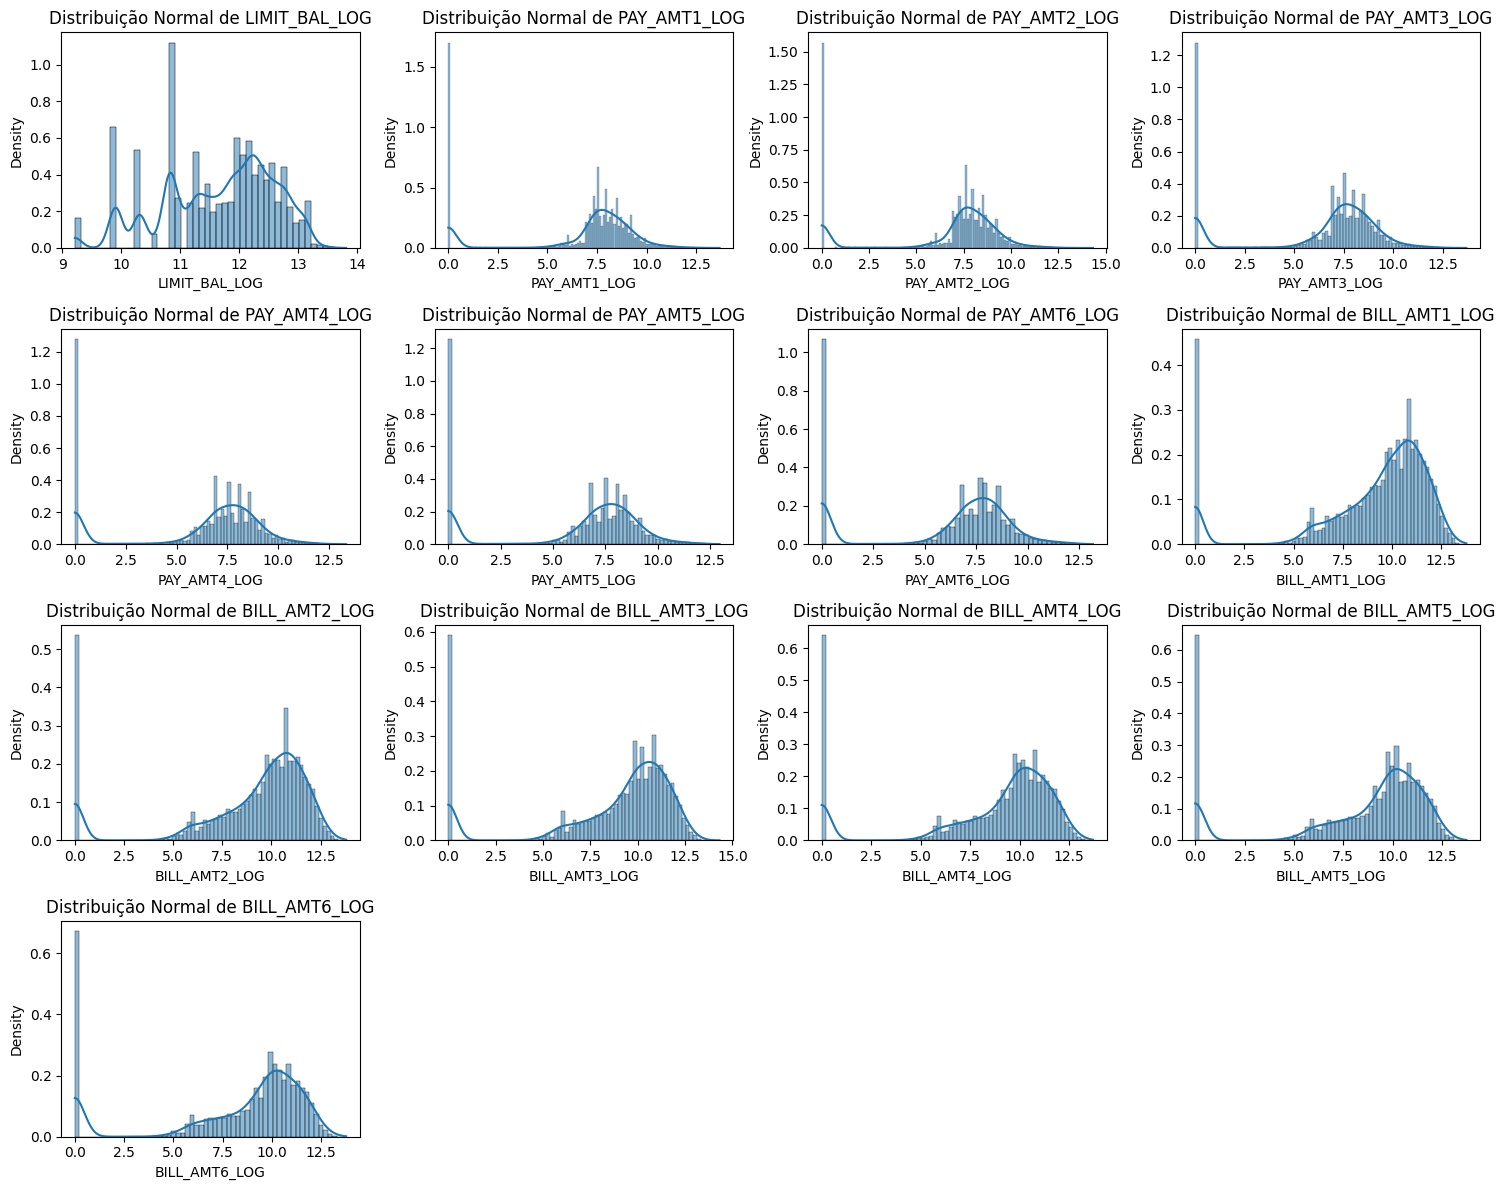

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotar a distribuição normal para cada variável numérica
plt.figure(figsize=(15, 12))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df_numeric[var], kde=True, stat="density")
    plt.title(f'Distribuição Normal de {var}')

plt.tight_layout()
plt.show()


Rede Bayesiana

### Distribuição Categórica para varáveis categóricas

In [ ]:
# Definir as faixas etárias e os rótulos
bins = [20, 30, 40, 50, 60, 70, 80]  # Limites das faixas
labels = ['21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

# Criar uma nova coluna para as faixas etárias
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

# Converter as variáveis para o tipo categórico
df['MARRIAGE'] = df['MARRIAGE'].astype('category')
df['EDUCATION'] = df['EDUCATION'].astype('category')
df['PAY_0'] = df['PAY_0'].astype('category')
df['PAY_2'] = df['PAY_2'].astype('category')
df['PAY_3'] = df['PAY_3'].astype('category')
df['PAY_4'] = df['PAY_4'].astype('category')
df['PAY_5'] = df['PAY_5'].astype('category')
df['PAY_6'] = df['PAY_6'].astype('category')
df['AGE_GROUP'] = df['AGE_GROUP'].astype('category')  # Faixa etária também como categórica

categorical_vars = [
    'MARRIAGE', 'EDUCATION', 'AGE_GROUP',
    'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'default.payment.next.month'
]

df_categorical = df[categorical_vars]

df_categorical.head()

,MARRIAGE,EDUCATION,AGE_GROUP,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month
0,1,2,21-30,2,-1,-1,-2,-2,1
1,2,2,21-30,2,0,0,0,2,1
2,2,2,31-40,0,0,0,0,0,0
3,1,2,31-40,0,0,0,0,0,0
4,1,2,51-60,0,-1,0,0,0,0


Carreguando e Preparando os Dados
